# HPC Mini-Challenge 2 - Beschleunigung in Data Science
## Teil 2: GPU
#### FHNW - FS22

Original von S. Suter, angepasst für das HS22 von S. Marcin

Abgabe von: <font color='blue'>Joseph Weibel</font>

#### Ressourcen
* [Überblick GPU Programmierung](https://www.cherryservers.com/blog/introduction-to-gpu-programming-with-cuda-and-python)
* [CUDA Basic Parts](https://nyu-cds.github.io/python-gpu/02-cuda/)
* [Accelerate Code with CuPy](https://towardsdatascience.com/heres-how-to-use-cupy-to-make-numpy-700x-faster-4b920dda1f56)
* Vorlesungen und Beispiele aus dem Informatikkurs PAC (parallel computing), siehe resourcen
* CSCS "High-Performance Computing with Python" Kurs, Tag 3: 
    - JIT Numba GPU 1 + 2
    - https://youtu.be/E4REVbCVxNQ
    - https://github.com/eth-cscs/PythonHPC/tree/master/numba-cuda
    - Siehe auch aktuelles Tutorial von 2021
* [Google CoLab](https://colab.research.google.com/) oder ggf. eigene GPU.


In [1]:
#!pip install numba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
!nvidia-smi

Thu Dec 15 09:39:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    29W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Dummy Beispiel zum testen mit Numba

import math
from numba import vectorize
import numpy as np

@vectorize(['float32(float32)'], target='cuda')
def gpu_sqrt(x):
    return math.sqrt(x)
  

a = np.arange(4096,dtype=np.float32)
gpu_sqrt(a)

/usr/local/lib/python3.8/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


array([ 0.       ,  1.       ,  1.4142135, ..., 63.97656  , 63.98437  ,
       63.992188 ], dtype=float32)

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
import imageio
import numpy as np

subfolder = '001'
folders = os.path.join('/content/drive/MyDrive/adni_png', subfolder)

images = np.empty([7,256,170])
idx = 0
names = []
for filename in os.listdir(folders):
    if filename.endswith('.png') and '145' in filename:
        with open(os.path.join(folders, filename), 'r') as f:
            im = imageio.imread(f.name)
            names.insert(idx,f.name[-17:-4])
            images[idx,:,:] = im
            print (names[idx], im.shape)
            idx += 1
            
print(images.shape)

FileNotFoundError: ignored

In [22]:
m = images[0]
m = m -m.min() / m.max() - m.min() # normalize data 
u,s,vt = np.linalg.svd(m, full_matrices=False)

In [2]:
import numpy as np

m = np.random.normal(size=(1000, 1000))
u, s, vt = np.linalg.svd(m, full_matrices=False)

### 5 GPU Rekonstruktion

Implementiere eine SVD-Rekonstruktionsvariante auf der GPU oder in einem hybriden Setting. Code aus dem ersten Teil darf dabei verwendet werden. Wähle  bewusst, welche Teile des Algorithms in einem GPU Kernel implementiert werden und welche effizienter auf der CPU sind. Ziehe dafür Erkenntnisse aus dem ersten Teil mit ein. Es muss mindestens eine Komponente des Algorithmuses in einem GPU-Kernel implementiert werden. Dokumentiere Annahmen, welche du ggf. zur Vereinfachung triffst. Evaluiere, ob du mit CuPy oder Numba arbeiten möchtest. Diskutiere deine Entscheidungen in 150-200 Wörtern. 

Links:
* [Examples: Matrix Multiplikation](https://numba.readthedocs.io/en/latest/cuda/examples.html)

In [3]:
### BEGIN SOLUTION
from numba import cuda, float32
import math


@cuda.jit
def _reconstruct_svd_gpu_1(u, s, vt, reco):
  x, y = cuda.grid(2)

  if x < u.shape[0] and y < vt.shape[0]:
    sum = 0
    for k in range(s.shape[0]):
      sum += u[x, k] * s[k] * vt[k, y]

    reco[x, y] = sum

def reconstruct_svd_gpu_1(u, s, vt, k, threads_per_block=32):
  reco_h = np.zeros((u.shape[0], vt.shape[1]))

  reco_d = cuda.to_device(reco_h)
  u_d = cuda.to_device(u[:, 0:k])
  s_d = cuda.to_device(s[0:k])
  vt_d = cuda.to_device(vt[0:k, :])

  n_blocks_x = math.ceil(u.shape[0] / threads_per_block)
  n_blocks_y = math.ceil(vt.shape[0] / threads_per_block)

  _reconstruct_svd_gpu_1[
    (n_blocks_x, n_blocks_y), (threads_per_block, threads_per_block)
  ](u_d, s_d, vt_d, reco_d)

  return reco_d.copy_to_host()

### END SOLUTION

In [4]:
import matplotlib.pyplot as plt

reco = reconstruct_svd_gpu_1(u, s, vt, u.shape[1])
np.testing.assert_array_almost_equal(reco, m, decimal=3)

<font color='blue'>Bei dieser einfachen Implementierung wird die gesamte Berechnung auf der GPU vorgenommen. Jeder Thread ist für ein einzelnes Pixel in der Rekonstruktion verantwortlich. Das Kürzen der Matrizen und Vektoren auf n Komponenten wird auf der CPU vorgenommen, beziehungsweise werden nur die nötigen Elemente auf die GPU kopiert. Dadurch wird verhindert, dass Elemente zur GPU kopiert werden, die dort gar nicht benötigt werden.

Die Anzahl Threads pro Block kann dabei frei definiert werden. Kleinere Grössen können sinnvoll sein, um dadurch die Rekonstruktionsgrösse genau aufteilen zu können, so dass möglichst keine Threads leer laufen. Bei einer Breite von 2000 px wäre es sinnvoller 25 oder 16 statt 32 zu verwenden.
TODO: stimmt das?

Es wird numba verwendet, da damit die grundelegenden GPU-Operationen simuliert werden können. Zudem kann damit Python-Code geschrieben werden, der dann autoamtisch in C-Code übersetzt wird.</font>

#### 5.2 GPU-Kernel Performance

##### 5.2.1 Blocks und Strided Access

Links: 
* [Examples: Matrix Multiplikation](https://numba.readthedocs.io/en/latest/cuda/examples.html)
* [NVIDIA Kapitel zu "Strided Access"](https://spaces.technik.fhnw.ch/multimediathek/file/cuda-best-practices-in-c)
* https://developer.nvidia.com/blog/cublas-strided-batched-matrix-multiply/
* https://developer.nvidia.com/blog/how-access-global-memory-efficiently-cuda-c-kernels/

Führe 2-3 Experimente mit unterschiedlichen Blockkonfigurationen und Strided Access durch, auf welchen dein GPU-Kernel arbeitet. Messe die Performance des GPU-Kernels mittels geeigneten Funktionen. Welche Blockgrösse und welcher Strided Access hat sich bei dir basierend auf deinen Experimenten als am erfolgreichsten erwiesen? Welches sind deiner Meinung nach die Gründe dafür? Wie sind die Performance Unterschiede zwischen deiner CPU und PGU Implementierung? Diskutiere deine Analyse in ca. 200 Wörtern und ggf. mit Grafiken. 

In [36]:
# import os
# os.environ["NUMBA_ENABLE_CUDASIM"] = "1"


In [5]:
### BEGIN SOLUTION
@cuda.jit
def _reconstruct_svd_gpu_2(u, s, vt, reco):
  # each thread calculates the sum of products for a specific index (x, y)

  x, y = cuda.grid(2)
  local_x = cuda.threadIdx.x
  local_y = cuda.threadIdx.y
  threads_per_block = 32 # cuda.blockDim.x but must be constant
  blocks_per_grid = cuda.gridDim.x

  shrd_u = cuda.shared.array(shape=(threads_per_block, threads_per_block), dtype=float32)
  shrd_s = cuda.shared.array(shape=(threads_per_block,), dtype=float32)
  shrd_vt = cuda.shared.array(shape=(threads_per_block, threads_per_block), dtype=float32)

  sum_of_products = float32(0.)
  for block in range(blocks_per_grid):
    # calculate sum of products per block
    # the block is only moved to get the other values in the matrices u, s and vt
    # the index for which the sum of product is calculated remains the same

    shrd_u[local_y, local_x] = 0
    if y < u.shape[0] and (block * threads_per_block + local_x) < u.shape[1]:
      shrd_u[local_y, local_x] = u[y, block * threads_per_block + local_x]

    if local_y == 0:
      shrd_s[local_x] = 0
      if (block * threads_per_block + local_x) < s.shape[0]:
        # only first row in block loads shrd_s since it's a one-dimensional array
        shrd_s[local_x] = s[block * threads_per_block + local_x]

    shrd_vt[local_y, local_x] = 0
    if x < vt.shape[1] and (block * threads_per_block + local_y) < vt.shape[0]:
      shrd_vt[local_y, local_x] = vt[block * threads_per_block + local_y, x]

    # wait until all tpb x tpb elements are filled
    cuda.syncthreads()

    # start calculating the sum of products for index (y, x)
    for i in range(threads_per_block):
      # no checking of boundaries necessary since the warp executes the
      # statement anyway and threads out of bound would have to wait anyway
      sum_of_products += shrd_u[local_y, i] * shrd_s[i] * shrd_vt[i, local_x]

    # wait until all threads have computed their sum of products before we move
    # to the next block as the shared values will be overridden with the next
    # iteration
    cuda.syncthreads()

  if y < reco.shape[0] and x < reco.shape[1]:
    reco[y, x] = sum_of_products

def reconstruct_svd_gpu_2(u, s, vt, k, threads_per_block=32):
  reco_h = np.zeros((u.shape[0], vt.shape[1]))

  reco_d = cuda.to_device(reco_h)
  u_d = cuda.to_device(u[:, 0:k])
  s_d = cuda.to_device(s[0:k])
  vt_d = cuda.to_device(vt[0:k, :])

  grid_y_max = max(u.shape[0], k)
  grid_x_max = max(k, vt.shape[1])

  n_blocks_x = math.ceil(grid_x_max / threads_per_block)
  n_blocks_y = math.ceil(grid_y_max / threads_per_block)

  _reconstruct_svd_gpu_2[
    (n_blocks_x, n_blocks_y), (threads_per_block, threads_per_block)
  ](u_d, s_d, vt_d, reco_d)

  return reco_d.copy_to_host()

### END SOLUTION

In [6]:
reco = reconstruct_svd_gpu_2(u, s, vt, u.shape[1])
np.testing.assert_array_almost_equal(reco, m, decimal=3)


<font color='blue'>Die erste Version hat ein schlechtes Verhältnis von Memory- zu Computation-Operationen. Es wird bei jeder Berechnung dreimal aufs Memory zugegriffen, ohne dass diese Werte nochmals verwendet werden. Diese optimierte Variante kopiert nun blockweise die benötigten Werte ins Shared-Memory wo sie von allen Threads desselben Blocks ebenfalls verwendet werden können. Da bei diesen Matrixmultiplikationen sehr viele Elemente wiederverwendet werden können, ist diese Implementierung um einiges schneller als die letzte, auch wenn nach wie vor alle Elemente mehrmals kopiert werden, da sie auch von anderen Blocks verwendet werden.</font>

##### 5.2.2 Memoryallokation auf der GPU
Führe 2-3 Experimente durch in welchem du unterschiedliche Varianten des Transfers der Daten bzw. der Memory-Allokation auf die GPU miteinander vergleichst. Messe die Varianten mittels geeigneten Methoden. Als Beispiel können hier z.B. unterschiedlich grosse Packages an Daten auf die GPU kopiert und dann verarbeitet werden oder die Daten werden in unterschiedliche Memory-Typen geladen.

Links:
* [Best Practices Memory Optimizations](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html#memory-optimizations)
* [Examples: Matrix Multiplikation und Shared Memory](https://numba.readthedocs.io/en/latest/cuda/examples.html)

###### Antwort

<font color='blue'></font>

In [18]:
### BEGIN SOLUTION
@cuda.jit
def _reconstruct_svd_gpu_3(u, s, vt, reco):
  # each thread calculates the sum of products for a specific index (x, y)

  x, y = cuda.grid(2)
  local_x = cuda.threadIdx.x
  local_y = cuda.threadIdx.y
  threads_per_block = 32 # cuda.blockDim.x but must be constant
  blocks_per_grid = cuda.gridDim.x

  shrd_u = cuda.shared.array(shape=(threads_per_block, threads_per_block), dtype=float32)
  shrd_s = cuda.shared.array(shape=(threads_per_block,), dtype=float32)
  shrd_vt = cuda.shared.array(shape=(threads_per_block, threads_per_block), dtype=float32)

  sum_of_products = float32(0.)
  for block in range(blocks_per_grid):
    # calculate sum of products per block
    # the block is only moved to get the other values in the matrices u, s and vt
    # the index for which the sum of product is calculated remains the same

    shrd_u[local_y, local_x] = 0
    if y < u.shape[0] and (block * threads_per_block + local_x) < u.shape[1]:
      # copy values in transposed order
      shrd_u[local_y, local_x] = u[y, block * threads_per_block + local_x]

    if local_y == 0:
      shrd_s[local_x] = 0
      if (block * threads_per_block + local_x) < s.shape[0]:
        # only first row in block loads shrd_s since it's a one-dimensional array
        shrd_s[local_x] = s[block * threads_per_block + local_x]

    shrd_vt[local_x, local_y] = 0
    if x < vt.shape[1] and (block * threads_per_block + local_y) < vt.shape[0]:
      shrd_vt[local_x, local_y] = vt[block * threads_per_block + local_y, x]

    # wait until all tpb x tpb elements are filled
    cuda.syncthreads()

    # start calculating the sum of products for index (y, x)
    for i in range(threads_per_block):
      # no checking of boundaries necessary since the warp executes the
      # statement anyway and threads out of bound would have to wait anyway

      # read values from shred_u in transposed order
      sum_of_products += shrd_u[local_y, i] * shrd_s[i] * shrd_vt[local_x, i]

    # wait until all threads have computed their sum of products before we move
    # to the next block as the shared values will be overridden with the next
    # iteration
    cuda.syncthreads()

  if y < reco.shape[0] and x < reco.shape[1]:
    reco[y, x] = sum_of_products

def reconstruct_svd_gpu_3(u, s, vt, k, threads_per_block=32):
  reco_h = np.zeros((u.shape[0], vt.shape[1]))

  reco_d = cuda.to_device(reco_h)
  u_d = cuda.to_device(u[:, 0:k])
  s_d = cuda.to_device(s[0:k])
  vt_d = cuda.to_device(vt[0:k, :])

  grid_y_max = max(u.shape[0], k)
  grid_x_max = max(k, vt.shape[1])

  n_blocks_x = math.ceil(grid_x_max / threads_per_block)
  n_blocks_y = math.ceil(grid_y_max / threads_per_block)

  _reconstruct_svd_gpu_2[
    (n_blocks_x, n_blocks_y), (threads_per_block, threads_per_block)
  ](u_d, s_d, vt_d, reco_d)

  return reco_d.copy_to_host()

### END SOLUTION

In [19]:
reco = reconstruct_svd_gpu_3(u, s, vt, u.shape[1])
np.testing.assert_array_almost_equal(reco, m, decimal=3)


Was sind deine Erkenntnisse bzgl. GPU-Memory-Allokation und des Daten-Transferes auf due GPU? Wie hast du ggf. deine Implementierung aus 5.1 angepasst? Diskutiere deine Antwort in ca. 150-200 Wörtern.

<font color='blue'>Diese Implementierung versucht Bank-Conflicts beim Zugriff auf das Shared-Memory zu vermeiden. Auf `shrt_vt` wurde bisher in einem Warp jeweils pro Iteration auf dieselbe Spalte zugegriffen. Dadurch kam es zu 32 Bank Conflicts, was dazu führte, dass jedes Element separat aus dem Shared-Memory abgerufen werden musste. Neu ist `shrt_vt` transponiert, so dass im Warp jeweils eine ganze Zeile abgerufen werden kann.</font>

##### 5.2.3 Bonus: Memoryoptimierung
Optimiere die Memory-Allokation in deiner Implementierung, so dass du einen Leistungssteigerung zu einer anderen Variante demonstrieren kannst.

###### Antwort


In [23]:
### BEGIN SOLUTION
@cuda.jit
def _reconstruct_svd_gpu_4(u, s, vt, reco):
  # each thread calculates the sum of products for a specific index (x, y)

  x, y = cuda.grid(2)
  local_x = cuda.threadIdx.x
  local_y = cuda.threadIdx.y
  threads_per_block = 32 # cuda.blockDim.x but must be constant
  blocks_per_grid = cuda.gridDim.x

  shrd_u = cuda.shared.array(shape=(threads_per_block, threads_per_block), dtype=float32)
  shrd_s = cuda.shared.array(shape=(threads_per_block,), dtype=float32)
  shrd_vt = cuda.shared.array(shape=(threads_per_block, threads_per_block), dtype=float32)
  shrd_u_pre = cuda.shared.array(shape=(threads_per_block, threads_per_block), dtype=float32)
  shrd_s_pre = cuda.shared.array(shape=(threads_per_block,), dtype=float32)
  shrd_vt_pre = cuda.shared.array(shape=(threads_per_block, threads_per_block), dtype=float32)

  shrd_u_pre[local_y, local_x] = 0
  if y < u.shape[0] and local_x < u.shape[1]:
    # copy values in transposed order
    shrd_u_pre[local_y, local_x] = u[y, local_x]

  if local_y == 0:
    shrd_s_pre[local_x] = 0
    if local_x < s.shape[0]:
      # only first row in block loads shrd_s since it's a one-dimensional array
      shrd_s_pre[local_x] = s[local_x]

  shrd_vt_pre[local_x, local_y] = 0
  if x < vt.shape[1] and local_y < vt.shape[0]:
    shrd_vt_pre[local_x, local_y] = vt[local_y, x]

  # wait until all tpb x tpb elements are filled
  cuda.syncthreads()

  sum_of_products = float32(0.)
  for block in range(blocks_per_grid):
    # calculate sum of products per block
    # the block is only moved to get the other values in the matrices u, s and vt
    # the index for which the sum of product is calculated remains the same

    # swap shared memory blocks
    shrd_u, shrd_u_pre = shrd_u_pre, shrd_u
    shrd_s, shrd_s_pre = shrd_s_pre, shrd_s
    shrd_vt, shrd_vt_pre = shrd_vt_pre, shrd_vt

    next_block = block + 1

    # load next block
    shrd_u_pre[local_y, local_x] = 0
    if y < u.shape[0] and (next_block * threads_per_block + local_x) < u.shape[1]:
      # copy values in transposed order
      shrd_u_pre[local_y, local_x] = u[y, next_block * threads_per_block + local_x]

    if local_y == 0:
      shrd_s_pre[local_x] = 0
      if (next_block * threads_per_block + local_x) < s.shape[0]:
        # only first row in block loads shrd_s since it's a one-dimensional array
        shrd_s_pre[local_x] = s[next_block * threads_per_block + local_x]

    shrd_vt_pre[local_x, local_y] = 0
    if x < vt.shape[1] and (next_block * threads_per_block + local_y) < vt.shape[0]:
      shrd_vt_pre[local_x, local_y] = vt[next_block * threads_per_block + local_y, x]

    # start calculating the sum of products for index (y, x) and the current block
    for i in range(threads_per_block):
      # no checking of boundaries necessary since the warp executes the
      # statement anyway and threads out of bound would have to wait anyway

      # read values from shred_u in transposed order
      sum_of_products += shrd_u[local_y, i] * shrd_s[i] * shrd_vt[local_x, i]

    # wait until all threads have computed their sum of products before we move
    # to the next block as the shared values will be overridden with the next
    # iteration
    cuda.syncthreads()

  if y < reco.shape[0] and x < reco.shape[1]:
    reco[y, x] = sum_of_products

def reconstruct_svd_gpu_4(u, s, vt, k, threads_per_block=32):
  reco_h = np.zeros((u.shape[0], vt.shape[1]))

  reco_d = cuda.to_device(reco_h)
  u_d = cuda.to_device(u[:, 0:k])
  s_d = cuda.to_device(s[0:k])
  vt_d = cuda.to_device(vt[0:k, :])

  grid_y_max = max(u.shape[0], k)
  grid_x_max = max(k, vt.shape[1])

  n_blocks_x = math.ceil(grid_x_max / threads_per_block)
  n_blocks_y = math.ceil(grid_y_max / threads_per_block)

  _reconstruct_svd_gpu_4[
    (n_blocks_x, n_blocks_y), (threads_per_block, threads_per_block)
  ](u_d, s_d, vt_d, reco_d)

  return reco_d.copy_to_host()

### END SOLUTION

In [24]:
reco = reconstruct_svd_gpu_4(u, s, vt, u.shape[1])
np.testing.assert_array_almost_equal(reco, m, decimal=3)


<font color='blue'>Bei dieser Optimierung passiert der Kopiervorgang vom Shared-Memory ins globale Memory nun asynchron zu den Berechnungen. Währenddem das Resultat für den aktuellen Block berechnet wird, werden bereits die Elemente des nächsten Blocks kopiert, so dass sie teilweise oder gar vollständig bereitstehen, wenn die Berechnungen des nächsten Blocks anstehen. Dazu wird jedoch doppelt soviel Speicher im Shared-Memory benötigt. Die GPU kann so aber besser ausgelastet werden.</font>

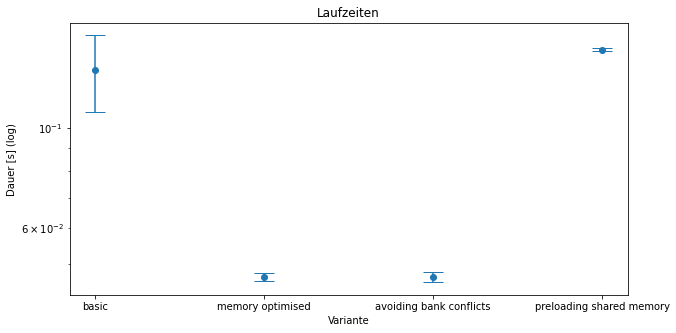

In [25]:
### BEGIN SOLUTION
import pandas as pd
import timeit

def plot_runtimes(names, fncs):
    times = []
    for fnc in fncs:
        times.append(timeit.repeat(lambda: fnc(u, s, vt, u.shape[0]), number=3, repeat=30))
        
    times = np.array(times)
    
    y = times.mean(axis=1)
    plt.figure(figsize = (10, 5))
    plt.errorbar(
        names,
        y,
        times.std(axis=1),
        linestyle='None',
        marker='o', 
        capsize=10
    )
    plt.title('Laufzeiten')
    plt.xlabel('Variante')
    plt.ylabel('Dauer [s] (log)')
    plt.yscale('log')
    plt.show()

    results = pd.DataFrame({'fnc': names, 'mean duration (s)': y})
    results.fnc = results.fnc.str.replace('\n', '')
    results

plot_runtimes(
    ['basic', 'memory optimised', 'avoiding bank conflicts', 'preloading shared memory'],
    [reconstruct_svd_gpu_1, reconstruct_svd_gpu_2, reconstruct_svd_gpu_3, reconstruct_svd_gpu_4]
)


### END SOLUTION

<font color='blue'>Beim Vergleich der Laufzeiten dieser vier GPU-Varianten lässt sich schnell erkennen, dass die Basic-Variante die Vorteile einer GPU nicht nutzt, da sie das Paradigma Single-Instruction-Multiple-Data nicht anwendet. Für jede einzelne Berechnung müssen drei Werte aus dem Global-Memory der GPU kopiert werden, was viel Zeit kostet.

Die optimierte Variante kopiert blockweise Werte der zwei Matrizen und des Vektors in das Shared-Memory, wo die Werte vom gesamten Threadblock verwendet werden können. Dadurch wird die Anzahl Zugriffe aufs Global-Memory stark reduziert, was sich einer viel kürzeren Laufzeit bemerkbar macht. Durch die Vermeidung von Bank-Conflicts bei der dritten Version verringert sich die Laufzeit nochmals, aber nur minim. Das Preloading vom Global-Memory ins Shared-Memory scheint nicht zu funktioniert. Die Laufzeit ist bei dieser Version ziemlich hoch. Möglicherweise können durch den doppelt so hohen Shared-Memoryverbrauch nicht mehr gleich viele Threads in einem Threadblock gleichzeitig ausgeführt werden, da für die Verwaltung der Threads nicht ausreichend Memory zur Verfügung steht. Die reduzierte Gleichläufigkeit hat dabei einen viel grösseren negativen Effekt als das Vorladen des Memorys wieder wett machen kann.</font>

#### 5.3 NVIDIA Profiler

Benutze einen Performance Profiler von NVIDIA, um Bottlenecks in deinem Code zu identifizieren bzw. unterschiedliche Implementierungen (Blocks, Memory etc.) zu vergleichen. 

* Siehe Beispiel example_profiling_CUDA.ipynb
* [Nsight](https://developer.nvidia.com/nsight-visual-studio-edition) für das Profiling des Codes und die Inspektion der Ergebnisse (neuste Variante)
* [nvprof](https://docs.nvidia.com/cuda/profiler-users-guide/index.html#nvprof-overview)
* [Nvidia Visual Profiler](https://docs.nvidia.com/cuda/profiler-users-guide/index.html#visual)

> Du kannst NVIDIA Nsights Systems und den Nvidia Visual Profiler auf deinem PC installieren und die Leistungsergebnisse aus einer Remote-Instanz visualisieren, auch wenn du keine GPU an/in deinem PC hast. Dafür kannst du die ``*.qdrep`` Datei generieren und danach lokal laden.


Dokumentiere deine Analyse ggf. mit 1-2 Visualisierungen und beschreibe in 3-5 Sätzen, welche Bottlenecks du gefunden bzw. entschärft hast.

<font color='blue'>Antwort hier eingeben inkl. Bild.</font>

### 6 Beschleunigte Rekonstruktion mehrerer Bilder
#### 6.1 Implementierung
Verwende einige der in bisher gelernten Konzepte, um mehrere Bilder gleichzeitig parallel zu rekonstruieren. Weshalb hast du welche Konzepte für deine Implementierung verwenden? Versuche die GPU konstant auszulasten und so auch die verschiedenen Engines der GPU parallel zu brauchen. Diskutiere in ca. 250-300 Wörtern.

In [ ]:
### BEGIN SOLUTION

### END SOLUTION

<font color='blue'>Antwort hier eingeben</font>

#### 6.2 Analyse
Vergleiche den Speedup für deine parallele Implementierung im Vergleich zur seriellen Rekonstruktion einzelner Bilder. Analysiere und diskutiere in diesem Zusammenhang die Gesetze von Amdahl und Gustafson in ca. 300 Wörtern.

<font color='blue'>Antwort hier eingeben</font>

#### 6.3 Komponentendiagramm

Erstelle das Komponentendiagramm dieser Mini-Challenge für die Rekunstruktion mehrere Bilder mit einer GPU-Implementierung. Erläutere das Komponentendigramm in 3-4 Sätzen.


<font color='blue'>Antwort hier eingeben inkl. Bild(ern).</font>

### 7 Reflexion

Reflektiere die folgenden Themen indem du in 3-5 Sätzen begründest und anhand von Beispielen erklärst.

1: Was sind deiner Meinung nach die 3 wichtigsten Prinzipien bei der Beschleunigung von Code?

<font color='blue'>Antwort hier eingeben</font>

2: Welche Rechenarchitekturen der Flynnschen Taxonomie wurden in dieser Mini-Challenge wie verwendet?

<font color='blue'>Antwort hier eingeben</font>

3: Haben wir es in dieser Mini-Challenge hauptsächlich mit CPU- oder IO-Bound Problemen zu tun? Nenne Beispiele.

<font color='blue'>Da sich die Bilder bereits im Arbeitsspeicher befinden, haben wir es vor allem mit CPU-Problemen zu tun. Die Berechnung hat eine Komplexität von $O(n^3)$ und ist somit sehr rechenintensiv.</font>

4: Wie könnte diese Anwendung in einem Producer-Consumer Design konzipiert werden?

<font color='blue'>Antwort hier eingeben</font>

5: Was sind die wichtigsten Grundlagen, um mehr Performance auf der GPU in dieser Mini-Challenge zu erreichen?

<font color='blue'>Antwort hier eingeben</font>

6: Reflektiere die Mini-Challenge in ca. 300-500 Zeichen. Was ist gut gelaufen? Wo gab es Probleme? Wo hast du mehr Zeit als geplant gebraucht? Was hast du dabei gelernt? Was hat dich überrascht? Was hättest du zusätzlich lernen wollen? Würdest du gewisse Fragestellungen anders formulieren? Wenn ja, wie?

<font color='blue'>Antwort hier eingeben</font>